In [1]:
#1:TAKE DATASET INPUT FROM MNIST AND IMPOORT PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5 # number of times it sees a image
batch_size = 100 # number of images after which it changes its weights
learning_rate = 0.01 # learningg rate of a model

from torchvision import datasets,transforms #imports datasets such as mnist, and transforms a function that is commonly used to convert imges to tensors /process  them {crop,resize etc.}
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))])#transforms.RandomRotation(10),             # rotate by up to ±10 degrees
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]) # slight shift in aaxis

# normalizes pixel value in range from -1(black) to 1(white) using formula (pixel-mean)/std
# takes data and transforms it to tensors:a datatype which can store a single,listof  umbers of n dimension
# train set stores all the images from data directory and applies transforms or any other task/function
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset)-train_size
train_subset,val_subset = random_split(train_dataset, [train_size,val_size])# storing 80% in test_subset and 20 % in val_subset
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
# loads the data from set int batch sizes of 100
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)


In [2]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__() # parent classs sets up everything needed.

    self.convolution=nn.Sequential(
      nn.Conv2d(
            in_channels=1,# input images
            out_channels=16,# output images
            # for each dimension (widt or height)   output={[input+(2*padding)-kernel_size]/stride}+1
            kernel_size=5, # 5*5 matrix filter
            padding=2,
            stride=1,# no of pixels skipped by kernel
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),# for 1st layer input=1 and outputs 16 of size 14*14 output=([input/pooling_kernel])
        # for 2nd layer cconsiting of 16 outputs and 32 ouputs of size 7*7
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            padding=2,
            stride=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
     )
    self.out = nn.Linear(32*7*7,10)# gives 10 output
  def forward(self,x):
    x=self.convolution(x)
    x=x.view(x.size(0),-1)
    output=self.out(x)
    return output




model = CNN() # creates object model
model = CNN().to(device)

In [3]:
cross_entropy = nn.CrossEntropyLoss() # a softmax function gives out probabilities btw 0 and 1
optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=1e-4) # used to change the value of weights and decay will punish the heavier weights

train_losses=[] # list of train data losses
test_losses=[] # list of test data losses
val_losses=[]
for epochs in range(num_epochs):
  train_loss=0.0 # initialize losses to 0
  test_loss=0.0
  val_loss=0.0
  for batch_idx, (images, labels) in enumerate(train_loader):# from train_loader it uses batch size to load images
    images, labels = images.to(device), labels.to(device) # sees where to compute the images
    optimizer.zero_grad() # initializes grad to 0

    x = Variable(images) # stores images
    y = Variable(labels) # stores labels of images

    y_pred = model(x) # gives output of the model
    loss = cross_entropy(y_pred,y) # calculates loss using the softmax function
    loss.backward() # backpropogates and calcultes the grad
    optimizer.step()# implements the lr for the weights and biases

    train_loss += loss.item()
  model.eval() #  switches to evaluation mode (turns off dropout, batch norm updates).
  with torch.no_grad():
    for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = cross_entropy(output, labels)
            val_loss += loss.item()

  model.eval() #  switches to evaluation mode (turns off dropout, batch norm updates).
  with torch.no_grad():
    for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = cross_entropy(output, labels)
            test_loss += loss.item()

    # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader)
  test_loss = test_loss/len(test_loader)
  val_loss = val_loss/len(val_loader)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  val_losses.append(val_loss)
  print(f"epoch {epochs+1}: train loss {train_loss}, test loss {test_loss},val loss {val_loss}")

epoch 1: train loss 0.1795519366346222, test loss 0.07727279577666195,val loss 0.0922580533195287
epoch 2: train loss 0.07645614255476782, test loss 0.06036067332606763,val loss 0.08210600251331926
epoch 3: train loss 0.0629140683246078, test loss 0.054300892255851066,val loss 0.07235407949192449
epoch 4: train loss 0.053664034561249234, test loss 0.058306769373011776,val loss 0.0750050986961772
epoch 5: train loss 0.05054831193362285, test loss 0.05059982945131196,val loss 0.07206654978217557


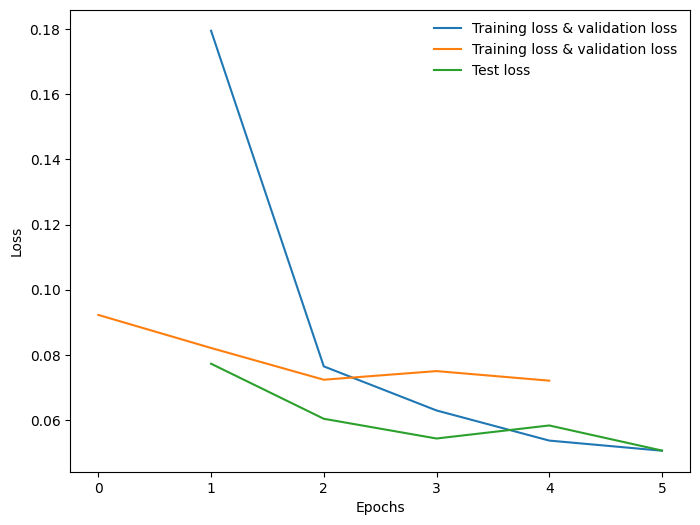

In [4]:

x_values = list(range(1, num_epochs+1)) # x axis values
plt.figure(figsize=(8., 6.))
plt.plot(x_values, train_losses,val_losses, label='Training loss & validation loss');# labeling and plotting
plt.plot(x_values, test_losses, label='Test loss');
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(frameon=False);

In [5]:
model.eval()
with torch.no_grad():# tellls not to calculate gradient
    correct, total = 0.0, 0.0 # initializes to zero
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)#inputs test loader images
        _, y_pred = torch.max(outputs.data, 1) # outputs the probablities and torch.max stores the output with max probability in y_pred
        total += labels.size(0)#total no. of images
        correct += (y_pred == labels).sum().item()# checks how many values are correct and stores them in sum
print('Accuracy: {}%'.format(100 * correct / total))
correct, total = 0.0, 0.0
for images, labels in train_loader:

   images, labels = images.to(device), labels.to(device)
   outputs = model(images)#inputs test loader images
   _, y_pred = torch.max(outputs.data, 1) # outputs the probablities and torch.max stores the output with max probability in y_pred
   total += labels.size(0)#total no. of images
   correct += (y_pred == labels).sum().item()# checks how many values are correct and stores them in sum
print('Accuracy: {}%'.format(100 * correct / total))
correct, total = 0.0, 0.0
for images, labels in val_loader:

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)#inputs test loader images
    _, y_pred = torch.max(outputs.data, 1) # outputs the probablities and torch.max stores the output with max probability in y_pred
    total += labels.size(0)#total no. of images
    correct += (y_pred == labels).sum().item()# checks how many values are correct and stores them in sum
print('Accuracy: {}%'.format(100 * correct / total))



Accuracy: 98.48%
Accuracy: 98.80416666666666%
Accuracy: 97.99166666666666%
